In [1]:
from chebai.result.base import ResultProcessor
from chebai.preprocessing.datasets.chebi import ChEBIOver100
from chebai.preprocessing.datasets.base import XYBaseDataModule
from chebai.models.electra import Electra
from chebai.models.base import ChebaiBaseNet
import torch
import os
import pandas as pd
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt
from torchmetrics.classification import MultilabelF1Score
import numpy as np
from chebai.result import pretraining as eval_pre
from chebai.preprocessing.datasets.pubchem import PubChemDeepSMILES

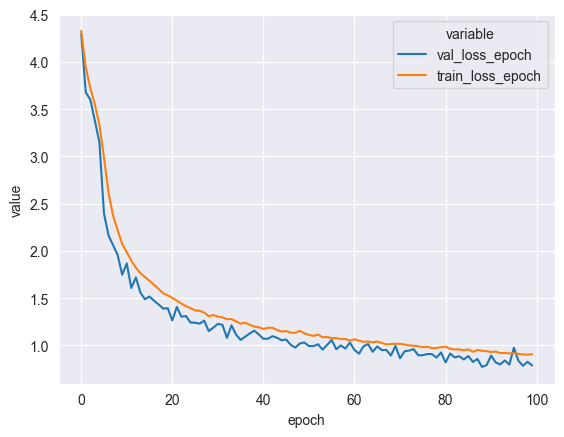

 70%|███████   | 8955/12750 [07:00<02:58, 21.30it/s]  


RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 288800 bytes.

In [2]:
logs_path = os.path.join('logs_server', 'pubchem_pretraining', 'version_6')
checkpoint_name = 'best_epoch=88_val_loss=0.7713_val_micro-f1=0.00.ckpt'
eval_pre.visualise_loss(logs_path)
eval_pre.evaluate_model(logs_path, checkpoint_name)
#todo: run on server

In [8]:
# check if pretraining datasets overlap
dm = PubChemDeepSMILES()
processed_path = dm.processed_dir
test_set = torch.load(os.path.join(processed_path, 'test.pt'))
val_set = torch.load(os.path.join(processed_path, 'validation.pt'))
train_set = torch.load(os.path.join(processed_path, 'train.pt'))
print(processed_path)
test_smiles = [entry['features'] for entry in test_set]
val_smiles = [entry['features'] for entry in val_set]
train_smiles = [entry['features'] for entry in train_set]
train_smiles.append(val_smiles[0])
val_smiles_in_test = [smiles for smiles in val_smiles if smiles in test_smiles]
train_smiles_in_val = [smiles for smiles in train_smiles if smiles in val_smiles]
print(val_smiles_in_test)
print(train_smiles_in_val)

data\Pubchem\processed\deepsmiles_token\100000
[]
[[118, 118, 118, 302, 222, 118, 349, 536, 272, 118, 349, 118, 278, 118, 349, 302, 136, 272, 272, 272, 272, 272, 272, 272, 272, 536, 118, 118, 349, 118, 118, 349, 118, 118, 349, 118, 118, 349, 118, 118, 349, 118, 675, 96]]


In [2]:
# not used
class CustomResultsProcessor(ResultProcessor):

    @classmethod
    def _identifier(cls) -> str:
        return 'custom_results_processor'

    def process_prediction(self, proc_id, features, labels, pred, ident):
        print(f'id: {proc_id}')
        print(f'features: {features}')
        print(f'labels: {labels}')
        print(f'pred: {pred}')

In [4]:
model_path_v148 = os.path.join('logs', 'chebi100_bce_unweighted', 'version_6', 'checkpoints',
                          'per_epoch=99_val_loss=0.0252_val_micro-f1=0.89.ckpt')
model_path_v227 =  os.path.join('logs', 'chebi100_bce_unweighted', 'version_8', 'checkpoints',
                          'per_epoch=99_val_loss=0.0167_val_micro-f1=0.91.ckpt')
model_path_v200 = 'electra_c100_bce_unweighted.ckpt'
model_v148 = Electra.load_from_checkpoint(model_path_v148).to('cpu')
model_v200 = Electra.load_from_checkpoint(model_path_v200).to('cpu')
model_v227 = Electra.load_from_checkpoint(model_path_v227).to('cpu')

data_module_v200 = ChEBIOver100()
data_module_v148 = ChEBIOver100(chebi_version_train=148)
data_module_v227 = ChEBIOver100(chebi_version_train=227)
#dataset = torch.load(data_path)
#processors = [CustomResultsProcessor()]
#factory = ResultFactory(model, data_module, processors)
#factory.execute(data_path)

In [7]:
filename_200 = 'classes.txt'
filename_148 = f'classes_v148.txt'
filename_227 = f'classes_v227.txt'
with open(os.path.join(data_module_v200.raw_dir, filename_200), "r") as file:
    v200_classes = file.readlines()
with open(os.path.join(data_module_v148.raw_dir, filename_148), "r") as file:
    v148_classes = file.readlines()
with open(os.path.join(data_module_v227.raw_dir, filename_227), "r") as file:
    v227_classes = file.readlines()

In [3]:
# construct mapping (not used)

# find index in orig_classes for every class in new_classes
mapping = []
for ind, v200_class in enumerate(v200_classes):
    if v200_class in v148_classes:
        mapping.append(v148_classes.index(v200_class))
    else:
        mapping.append(None)

In [4]:
# get list of classes that appear in v200 and v148
common_classes = []
for v200_class in v200_classes:
    if v200_class in v148_classes:
        common_classes.append(v200_class)
# get filter if a class in v200/v148 is a common class
common_classes_mask_v200 = torch.tensor([[c in common_classes for c in v200_classes]])
common_classes_mask_v148 = torch.tensor([[c in common_classes for c in v148_classes]])

In [9]:
# get list of classes that appear in v200 and v227
common_classes_v227 = []
for v227_class in v227_classes:
    if v227_class in v200_classes:
        common_classes_v227.append(v227_class)
# get filter if a class in v200/v148 is a common class
common_classes_with_v227_mask_for_v200 = torch.tensor([[c in common_classes_v227 for c in v200_classes]])
common_classes_with_v200_mask_for_v227 = torch.tensor([[c in common_classes_v227 for c in v227_classes]])

In [11]:
#print(len(common_classes))
print(len(common_classes_v227))

854


In [5]:
# (not used)
#mapping = [-1 if new_class not in orig_classes else orig_classes.index(new_class) for new_class in
#                   new_classes]
#input = torch.tensor(np.random.random([1, 854]))
def _apply_mapping(input, index):
    orig_ind = mapping[index]
    if orig_ind is not None:
        return input[0, orig_ind].item()
    return None
# mapping between model outputs / labels for chebi v200 (with 854 classes) and chebi v148 (with 709 classes)
def apply_mapping(mapping: [], input: torch.Tensor):
        input = input.detach().numpy()
        output = np.array(np.zeros((1, len(mapping))))
        for ind, value in enumerate(input[0]):
            if mapping[ind] is not None:
                output[0, mapping[ind]] = value
        return torch.tensor(output)


In [58]:
input = torch.Tensor([[3.4, 5.8, 6.2, 111, 405]])
print(input[0])
for ind, value in enumerate(input[0]):
    print(ind)
    print(mapping[ind])
print(apply_mapping(mapping, input))

tensor([  3.4000,   5.8000,   6.2000, 111.0000, 405.0000])
0
None
1
None
2
0
3
None
4
1
tensor([[  6.2000, 405.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.

In [12]:
# get predictions from model
def evaluate_model(model: ChebaiBaseNet, data_module: XYBaseDataModule, common_classes_mask = None, test_file=None):
    collate = data_module.reader.COLLATER()
    if test_file is None:
        test_file = data_module.processed_file_names_dict['test']
    data_path = os.path.join(data_module.processed_dir, test_file)
    data_list = torch.load(data_path)
    preds_list = []
    labels_list = []
    #if common_classes_mask is not N

    for row in tqdm.tqdm(data_list):
        processable_data = model._process_batch(collate([row]), 0)
        model_output = model(processable_data)
        # TODO: collect both masked and unmasked data if possible to avoid running the model twice
        preds, labels = model._get_prediction_and_labels(processable_data, processable_data["labels"], model_output)
        if common_classes_mask is not None:
            preds = preds[common_classes_mask]
            labels = labels[common_classes_mask]
            preds_list.append(preds.unsqueeze(0))
            labels_list.append(labels.unsqueeze(0))
        else:
            preds_list.append(preds)
            labels_list.append(labels)

    test_preds = torch.cat(preds_list)
    test_labels = torch.cat(labels_list)
    print(test_preds.shape)
    print(test_labels.shape)
    f1_macro = MultilabelF1Score(test_preds.shape[1], average='macro')
    f1_micro = MultilabelF1Score(test_preds.shape[1], average='micro')
    print(f'Macro-F1 on test set with {test_preds.shape[1]} classes: {f1_macro(test_preds, test_labels):3f}')
    print(f'Micro-F1 on test set with {test_preds.shape[1]} classes: {f1_micro(test_preds, test_labels):3f}')

In [11]:
evaluate_model(model_v200, data_module_v200, test_file='test_martin_server.pt')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16486/16486 [07:24<00:00, 37.09it/s]


torch.Size([16486, 854])
torch.Size([16486, 854])
Macro-F1 on test set with 854 classes: 0.603181
Micro-F1 on test set with 854 classes: 0.902437


Results:
- model_v200, test set from Martin:
  - Macro-F1 on test set with 854 classes: 0.607030
  - Micro-F1 on test set with 854 classes: 0.903165
- model_v200, test set from me (?) (i dont know where it is from, but it was there and lead to bad results)
- Macro-F1 on test set with 854 classes: 0.003233
- Micro-F1 on test set with 854 classes: 0.155634
- model_v200, test set from Martin (only using classes also present in chebi_v148):
  - Macro-F1 on test set with 701 classes: 0.623063
  - Micro-F1 on test set with 701 classes: 0.905059
- model_v227, full test set
  - Macro-F1 on test set with 940 classes: 0.593245
  - Micro-F1 on test set with 940 classes: 0.909714
  - evaluate_model(model_v227, data_module_v227)
Macro-F1 on test set with 854 classes: 0.649757
Micro-F1 on test set with 854 classes: 0.910626
- model_v148, test set from ?
  - Macro-F1 on test set: 0.510064
  - Micro-F1 on test set: 0.854736
- model_v148, test set from Martin (modified for training with 709 classes)
  - Macro-F1 on test set with 709 classes: 0.513283
  - Micro-F1 on test set with 709 classes: 0.854591
- model_v148, test set from Martin (modified for training with 709 classes, only using classes also present in chebi_v200)
  - Macro-F1 on test set with 701 classes: 0.519968
  - Micro-F1 on test set with 701 classes: 0.855442

In [40]:
evaluate_model(model_v200, data_module_v200, common_classes_mask_v200)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16486/16486 [07:21<00:00, 37.36it/s]


torch.Size([16486, 701])
torch.Size([16486, 701])
Macro-F1 on test set with 701 classes: 0.623063
Micro-F1 on test set with 701 classes: 0.905059


In [41]:
evaluate_model(model_v148, data_module_v148)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16486/16486 [05:31<00:00, 49.69it/s]


torch.Size([16486, 709])
torch.Size([16486, 709])
Macro-F1 on test set with 709 classes: 0.513283
Micro-F1 on test set with 709 classes: 0.854591


In [42]:
evaluate_model(model_v148, data_module_v148, common_classes_mask_v148)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16486/16486 [05:16<00:00, 52.07it/s]


torch.Size([16486, 701])
torch.Size([16486, 701])
Macro-F1 on test set with 701 classes: 0.519968
Micro-F1 on test set with 701 classes: 0.855442


In [13]:
evaluate_model(model_v227, data_module_v227)
evaluate_model(model_v227, data_module_v227, common_classes_with_v200_mask_for_v227)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16486/16486 [04:48<00:00, 57.15it/s]


torch.Size([16486, 940])
torch.Size([16486, 940])
Macro-F1 on test set with 940 classes: 0.593245
Micro-F1 on test set with 940 classes: 0.909714


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16486/16486 [05:57<00:00, 46.12it/s]


torch.Size([16486, 854])
torch.Size([16486, 854])
Macro-F1 on test set with 854 classes: 0.649757
Micro-F1 on test set with 854 classes: 0.910626


In [3]:
# visualize results from csv
df = pd.read_csv(os.path.join('logs_server', 'pubchem_pretraining', 'version_6', 'metrics.csv'))
df_loss = df.melt(id_vars='epoch', value_vars=['val_loss_epoch', 'train_loss_epoch'])
#df_macro = df.melt(id_vars='epoch', value_vars=['train_macro-f1', 'val_macro-f1', ])
#df_micro = df.melt(id_vars='epoch', value_vars=['train_micro-f1', 'val_micro-f1', ])
print(df_loss)

        epoch          variable    value
0         0.0    val_loss_epoch      NaN
1         0.0    val_loss_epoch      NaN
2         0.0    val_loss_epoch      NaN
3         0.0    val_loss_epoch      NaN
4         0.0    val_loss_epoch      NaN
...       ...               ...      ...
872995    NaN  train_loss_epoch      NaN
872996    NaN  train_loss_epoch      NaN
872997    NaN  train_loss_epoch      NaN
872998   99.0  train_loss_epoch      NaN
872999   99.0  train_loss_epoch  0.90625

[873000 rows x 3 columns]


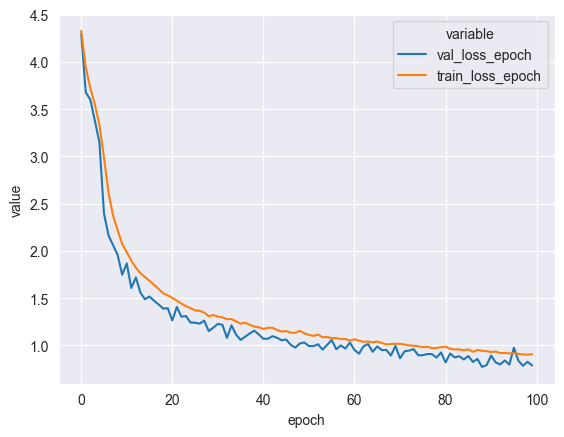

In [4]:
lineplt = sns.lineplot(df_loss, x='epoch', y='value', hue='variable')
plt.show()

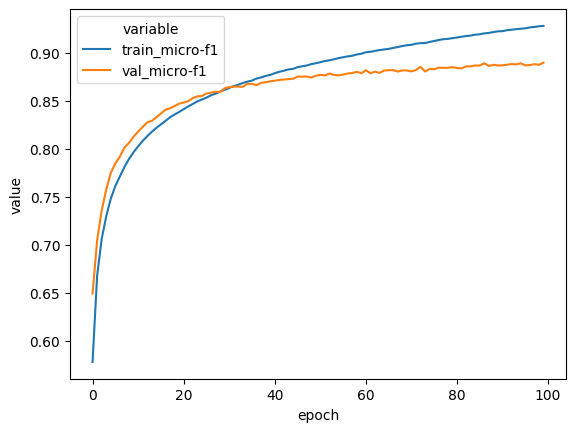

In [13]:
sns.lineplot(df_micro, x='epoch', y='value', hue='variable')
plt.show()

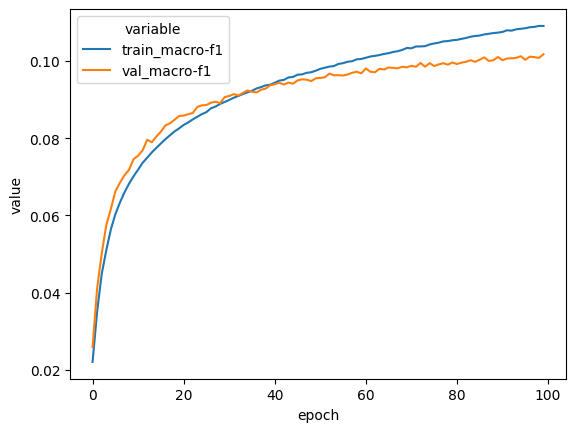

In [14]:
# values are not correct
sns.lineplot(df_macro, x='epoch', y='value', hue='variable')
plt.show()